# Inferencia con AE.tflite

## <span style="color:red">J. Oriol Moreno Usó</span> 

### Librerias

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time

### Datos

In [2]:
(x_train, y_train), (x_test, _) = mnist.load_data()

# DATOS
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

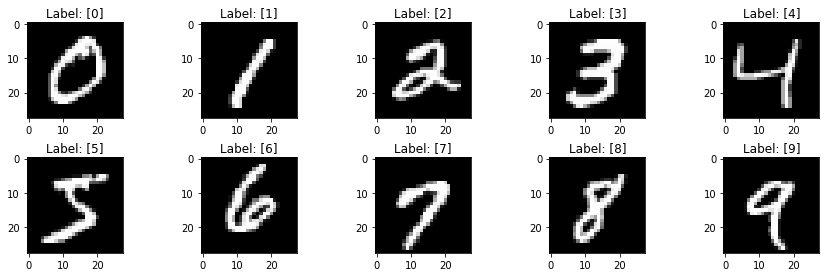

In [13]:
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(y_train == i)[0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax[i].set_title(f"Label: {y_train[im_idx]}")
    ax[i].imshow(plottable_image, cmap='gray')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

### Autoencoder

In [14]:
# ENCODER
input_img = Input(shape=(28, 28, 1))  
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# DECODER
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

opt = Adam(learning_rate=0.0001)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [16]:
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Fit

In [10]:
epochs = 1000
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=int(epochs*.25), verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('./checkpoints/cp.ckpt',
                                              save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=50, verbose=1, min_delta=1e-8, mode='min')

In [11]:
# ENTRENAMIENTO
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=128,
                validation_data=(x_test, x_test),
                callbacks=[earlyStopping,
                           mcp_save,
                           reduce_lr_loss])

Epoch 1/1000
469/469 [==============================] - 4s 7ms/step - loss: 0.0999 - val_loss: 0.0521

Epoch 00001: val_loss improved from inf to 0.05211, saving model to ./checkpoints\cp.ckpt
Epoch 2/1000
469/469 [==============================] - 3s 7ms/step - loss: 0.0431 - val_loss: 0.0365

Epoch 00002: val_loss improved from 0.05211 to 0.03649, saving model to ./checkpoints\cp.ckpt
Epoch 3/1000
469/469 [==============================] - 3s 7ms/step - loss: 0.0338 - val_loss: 0.0311

Epoch 00003: val_loss improved from 0.03649 to 0.03112, saving model to ./checkpoints\cp.ckpt
Epoch 4/1000
469/469 [==============================] - 3s 7ms/step - loss: 0.0298 - val_loss: 0.0280

Epoch 00004: val_loss improved from 0.03112 to 0.02802, saving model to ./checkpoints\cp.ckpt
Epoch 5/1000
469/469 [==============================] - 4s 8ms/step - loss: 0.0272 - val_loss: 0.0258

Epoch 00005: val_loss improved from 0.02802 to 0.02581, saving model to ./checkpoints\cp.ckpt
Epoch 6/1000
469/46

### Save model

### Inferencia y visualización

In [15]:
# autoencoder = tf.keras.models.load_model("./models/cnn_AE_mnist.h5")
t1 = time.time()
decoded_imgs = autoencoder.predict(x_test)
t2 = time.time()
print(f"Execute time: {round(t2 - t1, 2)} segs")

Execute time: 0.62 segs


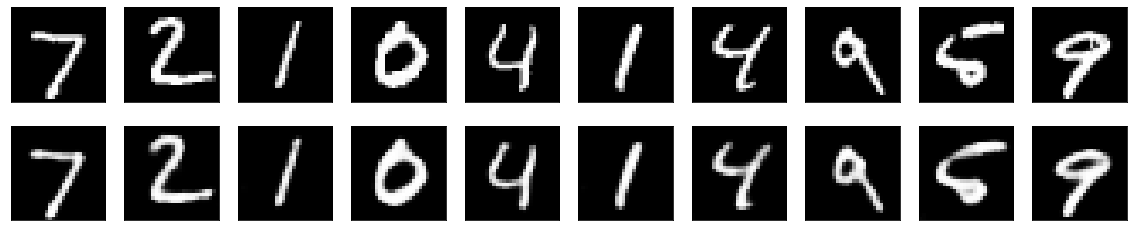

In [16]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
os.makedirs("models", exist_ok = True)
autoencoder.save("./models/cnn_AE_mnist_1.1_loss_0.00524.h5")

## TFlite part

### Conversión

In [8]:
tflite_model_path = "./models/cnn_AE_mnist_quant.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open(tflite_model_path, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\bchet\AppData\Local\Temp\tmp_y5oj32d\assets


16944

### Conversión en int8

In [19]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

In [30]:
tflite_model_path = "./models/cnn_AE_mnist_quant_1.1_int8.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_quant_model = converter.convert()
open(tflite_model_path, "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\bchet\AppData\Local\Temp\tmpdrjqj_bl\assets


INFO:tensorflow:Assets written to: C:\Users\bchet\AppData\Local\Temp\tmpdrjqj_bl\assets


22536

### Reshape para cambio del batch

In [31]:
tflite_model_path = "./models/cnn_AE_mnist_quant_1.1_int8.tflite"

tflite_interpreter = tf.lite.Interpreter(model_path = tflite_model_path)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: input_2
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>


In [32]:
# tflite_model_path = "./models/cnn_AE_mnist_quant.tflite"

tflite_interpreter = tf.lite.Interpreter(model_path = tflite_model_path)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (100, 28, 28, 1))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (100, 28, 28, 1))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()


print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: input_2
shape: [100  28  28   1]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [100  28  28   1]
type: <class 'numpy.float32'>


In [12]:
#test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(10)

### Prueba de batch

In [33]:
def iterate(array, batch):
    inf = 0
    sup = batch
    while sup < len(array)+batch:
        res = array[inf:sup, :, :]
        yield res
        inf += batch
        sup += batch

In [34]:
time_list = [[],[]]
for batch in range(10, len(x_test), 10):
    if len(x_test) % batch == 0: 
        tflite_interpreter.resize_tensor_input(input_details[0]['index'], (batch, 28, 28, 1))
        tflite_interpreter.resize_tensor_input(output_details[0]['index'], (batch, 28, 28, 1))
        tflite_interpreter.allocate_tensors()

        input_details = tflite_interpreter.get_input_details()
        output_details = tflite_interpreter.get_output_details()

        t1 = time.time()
        iterator_test = iterate(x_test, batch)
        results = []

        while True:
            try:    
                tflite_interpreter.set_tensor(input_details[0]['index'], next(iterator_test))

                tflite_interpreter.invoke()

                tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
                results.append(tflite_model_predictions)
            except:
                break
        t2 = time.time()
        time_list[0].append(t2-t1)
        time_list[1].append(batch)
    else:
        pass

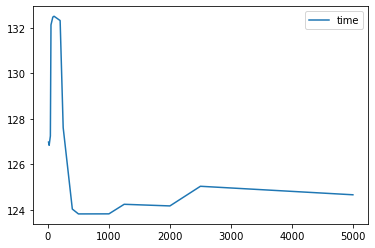

In [35]:
plt.figure
plt.plot(time_list[1],time_list[0],label="time")
plt.legend()
plt.show()

Como podemos observar, obtenemos el mínimo de tiempo de procesado con un batch de entre 500 y 1000 imágenes.

In [36]:
opt_batch = time_list[1][time_list[0].index(min(time_list[0]))]
print(f"Optimal batch size: {opt_batch}")

Optimal batch size: 500


In [37]:
batch = opt_batch
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (batch, 28, 28, 1))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (batch, 28, 28, 1))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

t1 = time.time()
iterator_test = iterate(x_test, batch)
results = []

while True:
    try:    
        tflite_interpreter.set_tensor(input_details[0]['index'], next(iterator_test))

        tflite_interpreter.invoke()

        tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
        results.append(tflite_model_predictions)
    except:
        break
t2 = time.time()
print(f"Execute time: {round(t2 - t1, 2)} segs")

Execute time: 124.27 segs


Dado que este dato de tiempo depende del hardware usado para hacer la inferencia, es un proceso determinista.

In [38]:
results = np.array(results).reshape(10000, 28, 28, 1)

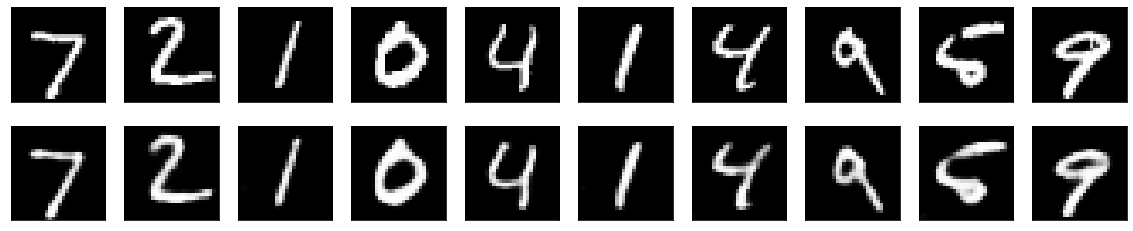

In [39]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(results[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

La reconstrucción con el modelo cuantizado es extremadamente bueno y con unas pérdidas mínimas respecto al modelo original en keras.